#### 무게를 찾기
- 목표 : 농어(Perch) 길이 피쳐를 사용해서 무게를 예측하기
- 데이터셋 : fish.csv
- 피쳐/속성 : Length
- 타겟/라벨 : Weight

[1] 데이터 준비 및 피쳐/타겟 분석

In [3]:
import pandas as pd    
import matplotlib.pyplot as plt 

In [4]:
DATA_FILE = '../data/fish.csv'

In [5]:
fishDF=pd.read_csv(DATA_FILE, usecols=[0,1,2])

In [6]:
fishDF

,Species,Weight,Length
0,Bream,242.0,25.4
1,Bream,290.0,26.3
2,Bream,340.0,26.5
3,Bream,363.0,29.0
4,Bream,430.0,29.0
...,...,...,...
154,Smelt,12.2,12.2
155,Smelt,13.4,12.4
156,Smelt,12.2,13.0
157,Smelt,19.7,14.3


In [7]:
mask =(fishDF['Species'] == 'Perch') 
Perch_DF=fishDF[mask]
Perch_DF.reset_index(drop=True, inplace=True)

In [8]:
Perch_DF.drop(columns='Species',inplace=True)

C:\Users\KDP-48\AppData\Local\Temp\ipykernel_8728\2192034215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Perch_DF.drop(columns='Species',inplace=True)


In [9]:
Perch_DF.corr(numeric_only=True)

,Weight,Length
Weight,1.000000,0.958656
Length,0.958656,1.000000


In [10]:
from scipy import stats

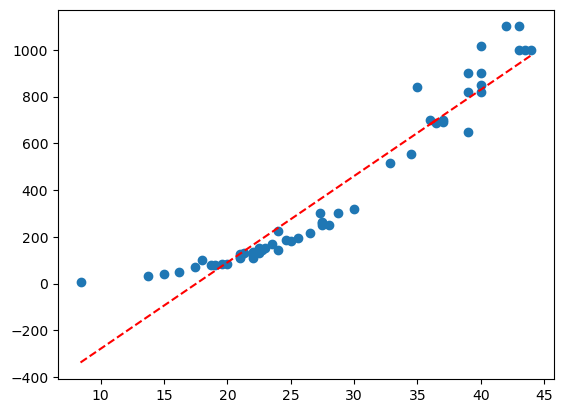

In [11]:
x = Perch_DF['Length']
y = Perch_DF['Weight']

slope, intercept, r, p, std_err = stats.linregress(x, y)

def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel,'r--')
plt.show()

[2] 학습 준비
- 학습 알고리즘 : KNN Regressor
- 피쳐 스케일링
- 학습용/테스트용 데이터셋 분리

- [2-1] 피쳐와 타겟 분리

In [12]:
featureDF = Perch_DF[['Length']]
targetSR = Perch_DF['Weight']

print(featureDF.shape, featureDF.ndim)
print(targetSR.shape, targetSR.ndim)

(56, 1) 2
(56,) 1


- [2-2] 학습용 & 테스트용 데이터셋 분리
* 전체 데이터셋 => 학습용: 테스트용 =75:25,  80:20,  70:30
* 회귀 데이터셋 => 데이터 셋 구성요소에 대한 비율 고려 X

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, 
                                                    targetSR,
                                                    test_size=0.2,
                                                    
                                                    random_state=42)

In [15]:
print(X_train.shape,X_train.ndim,y_train.shape,y_train.ndim)
print(X_test.shape,X_test.ndim,y_test.shape,y_test.ndim)

(44, 1) 2 (44,) 1
(12, 1) 2 (12,) 1


In [16]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


- [2-3] 피쳐 스케일링

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
# 스케일러 인스턴스 생성
mmScaler = MinMaxScaler()

In [19]:
# 스케일러에 데이터셋 전용에 속성값 설정
mmScaler.fit(X_train)

MinMaxScaler()

In [20]:
mmScaler.min_,mmScaler.scale_,mmScaler.data_min_,mmScaler.data_max_

(array([-0.45214521]), array([0.0330033]), array([13.7]), array([44.]))

In [21]:
# 학습용, 테스트용 데이터셋 스케일링 진행
X_train_scaled = mmScaler.transform(X_train)
X_test_scaled = mmScaler.transform(X_test)

[3] 학습 진행

In [22]:
from sklearn.neighbors import KNeighborsRegressor

# 학습용 모델 인스턴스 생성
model = KNeighborsRegressor()

# 학습용 데이터셋으로 학습 진행
model.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [23]:
# 모델 파라미터 => 학습 후 즉 , fit() 실행 후 설정되는 매개변수
model.n_features_in_,model.n_samples_fit_,model.effective_metric_,model.effective_metric_params_

(1, 44, 'euclidean', {})

[4] 최적의 K 찾기

In [24]:
scores = {}
for k in range(1,model.n_samples_fit_+1):
    # 최근접 이웃의 갯수 설정 <= 모델 성능 좌우: 하이퍼파라미터튜닝
    model.n_neighbors = k

    # 성능 평가
    score = model.score(X_test_scaled,y_test)
    
    scores[k] = score


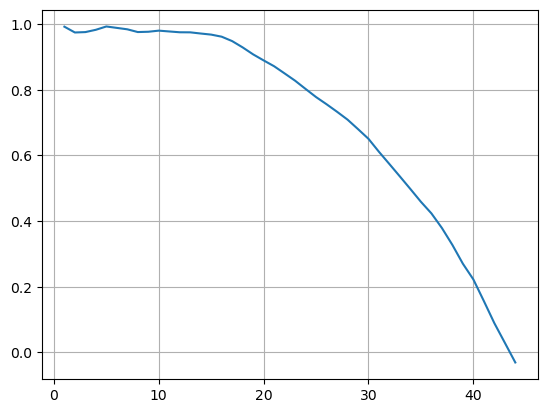

In [25]:
plt.plot(list(scores.keys()),list(scores.values()))
plt.grid()
plt.show()

In [26]:
# 최고 성능의 k 값
#                                x = (key,value)
best_k = sorted(scores.items(),key=lambda x:x[1],reverse=True)[0][0]
best_k

5

In [27]:
# 모델에 적용 => n_neighbors에 설정
model.n_neighbors = best_k

[5] 새로운 데이터의 무게 예측하기

In [28]:
new_length = input('농어 길이 : ')

In [29]:
print(new_length)

44


In [30]:
# 2D 데이터 프레임 만들기
dataDF = pd.DataFrame([new_length],columns=['Length'])

In [31]:
# 피쳐 스케일링
data_scaled = mmScaler.transform(dataDF)
data_scaled

array([[1.]])

In [32]:
# 예측
model.predict(data_scaled)

array([1010.])

In [33]:
distance,index = model.kneighbors(data_scaled)

print(distance,index, sep ='\n')

[[0.        0.0330033 0.0330033 0.0660066 0.1320132]]
[[36 10 16 42  8]]


In [34]:
X_train.iloc[index.reshape(-1)]

,Length
36,44.0
10,43.0
16,43.0
42,42.0
8,40.0


In [35]:
y_train[[36 ,10, 16, 42 , 8]]

36    1000.0
10    1000.0
16    1100.0
42    1100.0
8      850.0
Name: Weight, dtype: float64

In [36]:
y_train[index.reshape(-1)].sum()/model.n_neighbors

1010.0

##### KNN Regressor 단점

In [37]:
# 임의의 데이터
new_length=4
# 2D 데이터 프레임 만들기
dataDF = pd.DataFrame([new_length],columns=['Length'])
# 피쳐 스케일링
data_scaled = mmScaler.transform(dataDF)

In [38]:
model.predict(data_scaled)

array([60.])

=> 학습데이터셋의 범위를 벗어난 더 큰 데이터, 더 작은 데이터의 경우 정확한 예측 불가!!